<font color="black"><font size="7"><br>
     Project 7 - Advanced Model
</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import wordnet

import nltk

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from gensim.models import doc2vec

from collections import defaultdict

# Loading data

In [2]:
data=pd.read_csv("D:/Data OC/P7/sentiment140/training.1600000.processed.noemoticon.csv",header=None,names=['target','text'],usecols=[0,5])

We need to noramlize the target, reformat and save for futur use

In [3]:
data['target'] = data['target']/4

In [4]:
data = data.astype({'target':'int32'},copy=False)

In [5]:
data.to_csv('data/data_full.csv')

In [6]:
data = pd.read_pickle('data/data_full')

In [7]:
data.shape

(1600000, 2)

## Creating a common datasets for comapring performances across the three approachs

In [8]:
data_common = data.sample(n=1600,random_state=8)

In [9]:
data_common.to_csv('data/data_common.csv')

In [10]:
data_common.shape

(1600, 2)

In [11]:
data_common

,target,text
1516037,1,"Wow, its later than I feel, better wrap up ano..."
589923,0,@lemonissimo I think the reason I twitted so m...
213819,0,@GericaQuinn ahhhhh! dude u suck! lmao. jk! bu...
10047,0,...aaaand there goes that great day RIP Mrs W...
1330460,1,another morning joe free morning ahhhh ... sun...
...,...,...
622620,0,Damn packing trumps Xsport
232219,0,bout 2 call it a NIGHT... madd TIRED..gotta he...
1368574,1,"@IneffableNothin I love Pandora, but I am real..."
441029,0,@simoncurtis wish i could


### creating Json file for Azure deployment

In [12]:
data_common.to_json('data/data_common.json')

In [13]:
import json

In [14]:
data_json = pd.read_json('data/data_common.json')

In [15]:
data_json

,target,text
1516037,1,"Wow, its later than I feel, better wrap up ano..."
589923,0,@lemonissimo I think the reason I twitted so m...
213819,0,@GericaQuinn ahhhhh! dude u suck! lmao. jk! bu...
10047,0,...aaaand there goes that great day RIP Mrs W...
1330460,1,another morning joe free morning ahhhh ... sun...
...,...,...
622620,0,Damn packing trumps Xsport
232219,0,bout 2 call it a NIGHT... madd TIRED..gotta he...
1368574,1,"@IneffableNothin I love Pandora, but I am real..."
441029,0,@simoncurtis wish i could


## Removing common dataset from data

In [16]:
data = data.drop(index=data_common.index)

In [17]:
data.shape

(1598400, 2)

In [18]:
data.to_csv('data/data_training.csv')

# Exploratory analysis

## Target distribution

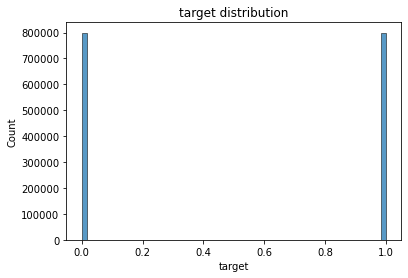

In [19]:
sns.histplot(data['target'])
plt.title('target distribution')
plt.show()

Acuuracy is a good metric for measuring a balanced classification

## Number of words per tweet

In [20]:
splitted_text = data.text.str.split()

In [21]:
nb_words =[len(text) for text in splitted_text.values]

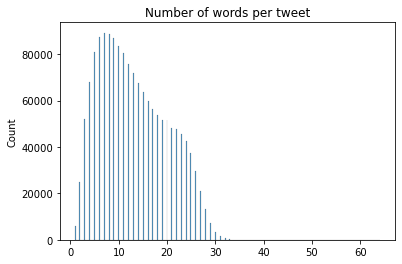

In [22]:
plt.title('Number of words per tweet')
sns.histplot(nb_words)
plt.show()

## Word frequency

In [23]:
dictionnary = {}
for sentence in splitted_text:
    for word in sentence:
        if word in dictionnary.keys():
            dictionnary[word]+=1
        else:
            dictionnary[word]=1
        

In [24]:
vocab = pd.DataFrame.from_dict(dictionnary,orient='index',columns=['nb_occur'])

In [25]:
vocab.shape

(1349319, 1)

In [26]:
vocab[vocab['nb_occur']>46].shape

(20193, 1)

In [27]:
vocab[vocab['nb_occur']>10].shape

(65637, 1)

# Preprocessing

## Tokenizer

In [28]:
def tokenizer(data, y = None):
    '''tokenizes input dataframe considering words of 2 and more characters
       and lowercase text and remove numbers
    
       Parameters
       ----------
       data : Pandas series to tokenize
       
       Returns
       --------
       Pandas series list of tokens'''
              
        
    tokenizer = nltk.RegexpTokenizer(r'\w{2,}')
    sentences = data.str.lower()
    sentences = sentences.str.replace('\d+', '',regex=True)
    results = sentences.apply(tokenizer.tokenize)
  
    return results

Create a transformer for pipeline integration

In [29]:
from sklearn.preprocessing import FunctionTransformer

In [30]:
tokenizer_transformer = FunctionTransformer(func=tokenizer)

## Stemming

In [31]:
from nltk.stem.porter import PorterStemmer

In [32]:
def stemmer(data, y = None, stemmer = PorterStemmer()):
    ''' Stems data using stemmer returns stems as a list of strings'''


    def stem_sentence(tokenized_sentence):
        stems = [stemmer.stem(i) for i in tokenized_sentence]
        return stems
    
    return data.apply(stem_sentence)


Create a transformer for pipeline integration

In [33]:
stemmer_transformer = FunctionTransformer(func=stemmer)

## Lemmatization

In [34]:
def lemmatizer(data, y = None, lemmatizer = WordNetLemmatizer()):
    
    def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize() accepts
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)


    def lem_sentence(tokenized_sentence):
        lems = [lemmatizer.lemmatize(i,pos=get_wordnet_pos(i)) for i in tokenized_sentence]
        return lems 

    
    return data.apply(lem_sentence)

Create a transformer for pipeline integration

In [35]:
lemmatizer_transformer = FunctionTransformer(func=lemmatizer)

## removing stop words

In [36]:
def remove_stopwords(data, stopwords = nltk.corpus.stopwords.words('english')):
    '''Remove stopwords from data'''

    # remove stopwords from stems and create a new column
    results = [[stem for stem in stems if (
        not(stem in stopwords))] for stems in data]
    
    return results

Create a transformer for pipeline integration

In [37]:
remove_stopwords_transformer = FunctionTransformer(remove_stopwords)

# Preprocessing Pipeline

## With stemming

In [38]:
from sklearn.pipeline import Pipeline

In [39]:
pipe_stem = Pipeline([('Tokenizer',tokenizer_transformer),
                      ('Stemmer',stemmer_transformer),
                      ])

## With lemmatization

In [40]:
pipe_lem = Pipeline([('Tokenizer',tokenizer_transformer),
                      ('lemmatizer',lemmatizer_transformer),
                      ])

# Word Embedding

## Fasttext Transformer

In [41]:
from gensim.models.fasttext import FastText as FT_gensim
from sklearn.base import BaseEstimator, TransformerMixin
import gensim

In [42]:
class Fastext_Transformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.model = FT_gensim(size=50,min_count=10,)     
        
        
    def build_doc2vec_corpus(self,texts):
        '''Returns a training corpus in the appropriate gensim Taggeddocument format'''
        results = []
        for tag,text in enumerate(texts):
            results.append(gensim.models.doc2vec.TaggedDocument(text,[tag]))
        return results

    def fit(self, X, y = None):
        self.train_corpus = list(self.build_doc2vec_corpus(X))
        self.model.build_vocab(sentences=X.values)
        self.model.train(X.values,
                         epochs=self.model.epochs,
                         total_examples=self.model.corpus_count,
                         total_words=self.model.corpus_total_words
                        )

        return self
    
    def vectorized_sentence(self,sentence):
        wordvecs_sent = [self.model.wv[word] for word in sentence]
        meanvec_sent = np.array(wordvecs_sent).mean(axis=0)
        return meanvec_sent
        
    
    
    def transform(self, X):
        return [self.vectorized_sentence(text) for text in X]
        

## Pre trained Glove Transformer

In [43]:
import gensim.downloader

we'll use the glove pretrained vector with a dimension of 100

In [44]:
glove_vectors = gensim.downloader.load('glove-twitter-100')

In [45]:
def vectorize_sentence_pretrained(sentence,Keyedvectors= glove_vectors):
    wordvecs_sent = [Keyedvectors[word] for word in sentence if word in Keyedvectors]
    if len(wordvecs_sent)>0:
        meanvec_sent = np.array(wordvecs_sent).mean(axis=0)
    else:
        meanvec_sent = np.zeros(Keyedvectors.vector_size)
    return meanvec_sent

def vectorize_corpus_glove(data):
    return [vectorize_sentence_pretrained(text) for text in data]

In [46]:
Glove_transformer = FunctionTransformer(func=vectorize_corpus_glove)

## Doc2vec transformer

In [47]:
class Doc2vec_Transformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=10, epochs=60)        
        self.train_corpus=[]
        
    def build_doc2vec_corpus(self,texts):
        '''Returns a training corpus in the appropriate gensim Taggeddocument format'''
        results = []
        for tag,text in enumerate(texts):
            results.append(gensim.models.doc2vec.TaggedDocument(text,[tag]))
        return results

    def fit(self, X, y = None):
        self.train_corpus = list(self.build_doc2vec_corpus(X))
        self.model.build_vocab(self.train_corpus)
        self.model.train(self.train_corpus, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        return self
    
    def transform(self, X):
        return [self.model.infer_vector(text) for text in X]
        
        

# Comparing preprocessings with Logistic regression

In [48]:
import time
from sklearn.metrics import accuracy_score,auc

## Downsampling dataset for reducing training time

In [49]:
#create a sample dataset for testing
data_sample = data.sample(n=10000,random_state=10)

In [50]:
from sklearn.model_selection import train_test_split
X = data_sample['text']
y = data_sample['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=33,stratify=y)

In [51]:
X_train.shape

(8000,)

In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
from sklearn.linear_model import LogisticRegression

## Dataframe for storing results

In [54]:
preprocessing_performances=pd.DataFrame(columns=['training_time (s)','Accuracy'])

## Fastext

### No preprocess

In [55]:
model_name='Fasttext - No preprocess'

pipe_fastext = Pipeline([    ('preprocessing',tokenizer_transformer),
                             ('embedding',Fastext_Transformer()),
                             ('scaler',StandardScaler()),
                             ('classifier', LogisticRegression(C=1e-2))])

start = time.time()
pipe_fastext.fit(X_train,y_train)
stop = time.time()

y_pred = pipe_fastext.predict(X_test)
preprocessing_performances = preprocessing_performances.append(
    pd.Series(data={'training_time (s)': stop-start,
              'Accuracy': accuracy_score(y_pred,y_test)},
              name=model_name)
)

In [56]:
preprocessing_performances

,training_time (s),Accuracy
Fasttext - No preprocess,29.219006,0.6105


### With lemmatization

In [57]:
model_name='Fasttext - Lemmatization'

pipe_lem_fastext = Pipeline([('preprocessing',pipe_lem),
                             ('embedding',Fastext_Transformer()),
                             ('scaler',StandardScaler()),
                             ('classifier', LogisticRegression(C=1e-2))])

In [58]:
start = time.time()
pipe_lem_fastext.fit(X_train,y_train)
stop = time.time()

In [59]:
y_pred = pipe_lem_fastext.predict(X_test)
preprocessing_performances = preprocessing_performances.append(
    pd.Series(data={'training_time (s)': stop-start,
              'Accuracy': accuracy_score(y_pred,y_test)},
              name=model_name)
)

### With stemming

In [37]:
model_name = 'Fasttext - stemming'

pipe_stem_fastext = Pipeline([('preprocessing',pipe_stem),
                             ('embedding',Fastext_Transformer()),
                             ('scaler',StandardScaler()),
                             ('classifier', LogisticRegression(C=1e-2))])

In [38]:
start = time.time()
pipe_stem_fastext.fit(X_train,y_train)
stop = time.time()

In [39]:
y_pred = pipe_stem_fastext.predict(X_test)
preprocessing_performances = preprocessing_performances.append(
    pd.Series(data={'training_time (s)': stop-start,
              'Accuracy': accuracy_score(y_pred,y_test)},
              name=model_name)
)

In [40]:
preprocessing_performances

,training_time (s),Accuracy
Fasttext - No preprocess,23.022785,0.510
Fasttext - stemming,7.574217,0.515


## Pre trained Glove

### No preprocessing

In [60]:
model_name='Glove - No preprocess'

pipe_glove = Pipeline([      ('preprocessing',tokenizer_transformer),
                             ('embedding',Glove_transformer),
                             ('scaler',StandardScaler()),
                             ('classifier', LogisticRegression(C=1e-2))])

start = time.time()
pipe_glove.fit(X_train,y_train)
stop = time.time()

y_pred = pipe_glove.predict(X_test)
preprocessing_performances = preprocessing_performances.append(
    pd.Series(data={'training_time (s)': stop-start,
              'Accuracy': accuracy_score(y_pred,y_test)},
              name=model_name)
)

### Wtih lemmatization

In [61]:
model_name = 'Glove - lemmatization'

pipe_lem_glove = Pipeline([('preprocessing',pipe_lem),
                             ('embedding',Glove_transformer),
                             ('scaler',StandardScaler()),
                             ('classifier', LogisticRegression(C=1e-2))])

In [62]:
start = time.time()
pipe_lem_glove.fit(X_train,y_train)
stop = time.time()

In [63]:
y_pred = pipe_lem_glove.predict(X_test)
preprocessing_performances = preprocessing_performances.append(
    pd.Series(data={'training_time (s)': stop-start,
              'Accuracy': accuracy_score(y_pred,y_test)},
              name=model_name)
)

### Wtih stemming

In [64]:
model_name = 'Glove - stemming'

pipe_stem_glove = Pipeline([('preprocessing',pipe_stem),
                             ('embedding',Glove_transformer),
                             ('scaler',StandardScaler()),
                             ('classifier', LogisticRegression(C=1e-2))])

In [65]:
start = time.time()
pipe_stem_glove.fit(X_train,y_train)
stop = time.time()

In [66]:
y_pred = pipe_stem_glove.predict(X_test)
preprocessing_performances = preprocessing_performances.append(
    pd.Series(data={'training_time (s)': stop-start,
              'Accuracy': accuracy_score(y_pred,y_test)},
              name=model_name)
)

## Doc2vec

## No preprocessing

In [67]:
model_name='Doc2vec - No preprocess'

pipe_doc2vec = Pipeline([    ('preprocessing',tokenizer_transformer),
                             ('embedding',Doc2vec_Transformer()),
                             ('scaler',StandardScaler()),
                             ('classifier', LogisticRegression(C=1e-2))])

start = time.time()
pipe_doc2vec.fit(X_train,y_train)
stop = time.time()

y_pred = pipe_doc2vec.predict(X_test)
preprocessing_performances = preprocessing_performances.append(
    pd.Series(data={'training_time (s)': stop-start,
              'Accuracy': accuracy_score(y_pred,y_test)},
              name=model_name)
)

### Wtih lemmatization

In [68]:
model_name = 'Doc2vec - lemmatization'

pipe_lem_doc2vec = Pipeline([('preprocessing',pipe_lem),
                             ('embedding',Doc2vec_Transformer()),
                             ('scaler',StandardScaler()),
                             ('classifier', LogisticRegression(C=1e-2))])

In [69]:
start = time.time()
pipe_lem_doc2vec.fit(X_train,y_train)
stop = time.time()

In [70]:
y_pred = pipe_lem_doc2vec.predict(X_test)
preprocessing_performances = preprocessing_performances.append(
    pd.Series(data={'training_time (s)': stop-start,
              'Accuracy': accuracy_score(y_pred,y_test)},
              name=model_name)
)

### Wtih stemming

In [71]:
model_name = 'Doc2vec - stemming'

pipe_stem_doc2vec = Pipeline([('preprocessing',pipe_stem),
                             ('embedding',Doc2vec_Transformer()),
                             ('scaler',StandardScaler()),
                             ('classifier', LogisticRegression(C=1e-2))])

In [72]:
start = time.time()
pipe_stem_doc2vec.fit(X_train,y_train)
stop = time.time()

In [73]:
y_pred = pipe_stem_doc2vec.predict(X_test)
preprocessing_performances = preprocessing_performances.append(
    pd.Series(data={'training_time (s)': stop-start,
              'Accuracy': accuracy_score(y_pred,y_test)},
              name=model_name)
)

## Results

In [74]:
preprocessing_performances

,training_time (s),Accuracy
Fasttext - No preprocess,29.219006,0.6105
Fasttext - Lemmatization,68.166595,0.6055
Glove - No preprocess,34.748743,0.7485
Glove - lemmatization,55.533927,0.7550
Glove - stemming,21.035625,0.7230
Doc2vec - No preprocess,48.887063,0.6955
Doc2vec - lemmatization,104.267337,0.6920
Doc2vec - stemming,52.889242,0.7185


# Neural Network

## Preparing text data to fit Keras requirement

the NN needs an input matrix with documents represented as an interger list, each interger is a word. we'll choose sequence length to be tweet_length(based on EDA it makes sense, if less than tweet_length use 0 padding) and vocabulary size max_token (based on preliminary EDA). We'll use Keras' vectorizer

In [75]:
tweet_length = 30
max_tokens = 60000

In [76]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Creating test and train sets

In [77]:
#create a sample dataset for testing
data_sample = data.sample(n=15000,random_state=10)

In [78]:
from sklearn.model_selection import train_test_split
X = data_sample['text']
y = data_sample['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=33,stratify=y)

In [79]:
def vectorize_sets(X_train,X_test,vocab_length=20000,tweet_length=30):
    '''Compute and return the vectors of the documents in X_train and X_test with a fixed length'''
    vectorizer = TextVectorization(max_tokens=vocab_length,output_sequence_length=tweet_length)
    vectorizer.adapt(X_train.values)
    voc = vectorizer.get_vocabulary() # vocabulary for futur use
    word_index = dict(zip(voc, range(len(voc)))) # word index for futur use
    return (vectorizer(X_train.values),vectorizer(X_test.values),voc,word_index)

### Raw tweets

In [80]:
X_train_raw, X_test_raw, voc_raw, word_index_raw = vectorize_sets(
    X_train,
    X_test,
    vocab_length=max_tokens,
    tweet_length=30)

### basic preprocessing

In [81]:
X_train_vect, X_test_vect, voc, word_index = vectorize_sets(
    tokenizer_transformer.transform(X_train).str.join(sep=' '),
    tokenizer_transformer.transform(X_test).str.join(sep=' '),
    vocab_length=max_tokens,
    tweet_length=30)

### Stemming

In [82]:
X_train_vect_stem, X_test_vect_stem, voc_stem, word_index_stem = vectorize_sets(
    stemmer_transformer.transform(tokenizer_transformer.transform(X_train)).str.join(sep=' '),
    stemmer_transformer.transform(tokenizer_transformer.transform(X_test)).str.join(sep=' '),
    vocab_length=max_tokens,
    tweet_length=30)

### Lemmatization

In [83]:
X_train_vect_lem, X_test_vect_lem, voc_lem, word_index_lem = vectorize_sets(
    lemmatizer_transformer.transform(tokenizer_transformer.transform(X_train)).str.join(sep=' '),
    lemmatizer_transformer.transform(tokenizer_transformer.transform(X_test)).str.join(sep=' '),
    vocab_length=max_tokens,
    tweet_length=30)

In [84]:
print(f' raw vocab length {len(voc_raw)} \n no processing vocab length {len(voc)} \n stem vocab length {len(voc_stem)} \n lem vocab length {len(voc_lem)}')

 raw vocab length 22953 
 no processing vocab length 20564 
 stem vocab length 17599 
 lem vocab length 18460


## Testing preprocessing on a simple Neural Network

In [95]:
import time

In [96]:
models_performances=pd.DataFrame(columns=['AUC','Accuracy','Epoch max reach'])

In [97]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

### Raw texts

In [98]:
model_name = 'simple NN - raw text'

model = Sequential()

model.add(Embedding(len(voc_raw),100 ,input_length = tweet_length))
model.add(Flatten())
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy','AUC'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           2295300   
_________________________________________________________________
flatten_1 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 24008     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,319,317
Trainable params: 2,319,317
Non-trainable params: 0
_________________________________________________________________
None


In [99]:
start = time.time()
hist = model.fit(X_train_raw, y_train, batch_size=1024, epochs=15, validation_data=(X_test_raw, y_test))
stop = time.time()

Epoch 1/15
12/12 [==============================] - 1s 84ms/step - loss: 0.6917 - accuracy: 0.5300 - auc: 0.5400 - val_loss: 0.6884 - val_accuracy: 0.5550 - val_auc: 0.5970
Epoch 2/15
12/12 [==============================] - 1s 56ms/step - loss: 0.6723 - accuracy: 0.6783 - auc: 0.7552 - val_loss: 0.6779 - val_accuracy: 0.5847 - val_auc: 0.6608
Epoch 3/15
12/12 [==============================] - 1s 59ms/step - loss: 0.6335 - accuracy: 0.7729 - auc: 0.8596 - val_loss: 0.6536 - val_accuracy: 0.6737 - val_auc: 0.7418
Epoch 4/15
12/12 [==============================] - 1s 61ms/step - loss: 0.5618 - accuracy: 0.8538 - auc: 0.9300 - val_loss: 0.6185 - val_accuracy: 0.6947 - val_auc: 0.7690
Epoch 5/15
12/12 [==============================] - 1s 65ms/step - loss: 0.4623 - accuracy: 0.8898 - auc: 0.9540 - val_loss: 0.5817 - val_accuracy: 0.7150 - val_auc: 0.7841
Epoch 6/15
12/12 [==============================] - 1s 64ms/step - loss: 0.3554 - accuracy: 0.9202 - auc: 0.9728 - val_loss: 0.5545 - v

In [100]:
models_performances = models_performances.append(
    pd.Series(data={'total training time': stop-start,
              'AUC': max(hist.history['val_auc']),
              'Accuracy': max(hist.history['val_accuracy']),
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

In [101]:
models_performances

,AUC,Accuracy,Epoch max reach,total training time,training time to opt
simple NN - raw text,0.814432,0.749333,8.0,12.445643,6.637676


### Basic preprocessing

In [102]:
model_name = 'simple NN - Basic preprocessing'

model = Sequential()

model.add(Embedding(len(voc),100 ,input_length = tweet_length))
model.add(Flatten())
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy','AUC'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 100)           2056400   
_________________________________________________________________
flatten_2 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 24008     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,080,417
Trainable params: 2,080,417
Non-trainable params: 0
_________________________________________________________________
None


In [103]:
start = time.time()
hist = model.fit(X_train_vect, y_train, batch_size=1024, epochs=15, validation_data=(X_test_vect, y_test))
stop = time.time()

Epoch 1/15
12/12 [==============================] - 1s 72ms/step - loss: 0.6922 - accuracy: 0.5347 - auc: 0.5360 - val_loss: 0.6893 - val_accuracy: 0.5690 - val_auc: 0.6001
Epoch 2/15
12/12 [==============================] - 1s 50ms/step - loss: 0.6763 - accuracy: 0.6695 - auc: 0.7381 - val_loss: 0.6799 - val_accuracy: 0.6153 - val_auc: 0.6823
Epoch 3/15
12/12 [==============================] - 1s 53ms/step - loss: 0.6371 - accuracy: 0.7940 - auc: 0.8793 - val_loss: 0.6518 - val_accuracy: 0.7013 - val_auc: 0.7605
Epoch 4/15
12/12 [==============================] - 1s 50ms/step - loss: 0.5522 - accuracy: 0.8660 - auc: 0.9362 - val_loss: 0.6030 - val_accuracy: 0.7180 - val_auc: 0.7835
Epoch 5/15
12/12 [==============================] - 1s 52ms/step - loss: 0.4298 - accuracy: 0.8908 - auc: 0.9570 - val_loss: 0.5602 - val_accuracy: 0.7200 - val_auc: 0.8001
Epoch 6/15
12/12 [==============================] - 1s 51ms/step - loss: 0.3106 - accuracy: 0.9242 - auc: 0.9776 - val_loss: 0.5354 - v

In [104]:
models_performances = models_performances.append(
    pd.Series(data={'total training time': stop-start,
              'AUC': max(hist.history['val_auc']),
              'Accuracy': max(hist.history['val_accuracy']),
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

In [105]:
models_performances

,AUC,Accuracy,Epoch max reach,total training time,training time to opt
simple NN - raw text,0.814432,0.749333,8.0,12.445643,6.637676
simple NN - Basic preprocessing,0.817025,0.731667,7.0,11.445507,5.341237


### Stemming

In [106]:
model_name = 'simple NN - Stemming'

model = Sequential()

model.add(Embedding(len(voc_stem),100 ,input_length = tweet_length))
model.add(Flatten())
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy','AUC'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           1759900   
_________________________________________________________________
flatten_3 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 24008     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,783,917
Trainable params: 1,783,917
Non-trainable params: 0
_________________________________________________________________
None


In [107]:
start = time.time()
hist = model.fit(X_train_vect_stem, y_train, batch_size=1024, epochs=15, validation_data=(X_test_vect_stem, y_test))
stop = time.time()

Epoch 1/15
12/12 [==============================] - 1s 67ms/step - loss: 0.6920 - accuracy: 0.5178 - auc: 0.5325 - val_loss: 0.6879 - val_accuracy: 0.5663 - val_auc: 0.6230
Epoch 2/15
12/12 [==============================] - 1s 47ms/step - loss: 0.6714 - accuracy: 0.6823 - auc: 0.7615 - val_loss: 0.6747 - val_accuracy: 0.5823 - val_auc: 0.7126
Epoch 3/15
12/12 [==============================] - 1s 46ms/step - loss: 0.6258 - accuracy: 0.8077 - auc: 0.8939 - val_loss: 0.6404 - val_accuracy: 0.7093 - val_auc: 0.7755
Epoch 4/15
12/12 [==============================] - 1s 47ms/step - loss: 0.5434 - accuracy: 0.8570 - auc: 0.9296 - val_loss: 0.5928 - val_accuracy: 0.7263 - val_auc: 0.7972
Epoch 5/15
12/12 [==============================] - 1s 52ms/step - loss: 0.4375 - accuracy: 0.8826 - auc: 0.9503 - val_loss: 0.5510 - val_accuracy: 0.7370 - val_auc: 0.8092
Epoch 6/15
12/12 [==============================] - 1s 49ms/step - loss: 0.3353 - accuracy: 0.9125 - auc: 0.9697 - val_loss: 0.5283 - v

In [108]:
models_performances = models_performances.append(
    pd.Series(data={'total training time': stop-start,
              'AUC': max(hist.history['val_auc']),
              'Accuracy': max(hist.history['val_accuracy']),
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

### Lemmatization

In [109]:
model_name = 'simple NN - Lemmatization'

model = Sequential()

model.add(Embedding(len(voc_lem),100 ,input_length = tweet_length))
model.add(Flatten())
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy','AUC'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 100)           1846000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 24008     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,870,017
Trainable params: 1,870,017
Non-trainable params: 0
_________________________________________________________________
None


In [110]:
start = time.time()
hist = model.fit(X_train_vect_lem, y_train, batch_size=1024, epochs=15, validation_data=(X_test_vect_lem, y_test))
stop = time.time()

Epoch 1/15
12/12 [==============================] - 1s 71ms/step - loss: 0.6924 - accuracy: 0.5162 - auc: 0.5299 - val_loss: 0.6903 - val_accuracy: 0.5253 - val_auc: 0.6114
Epoch 2/15
12/12 [==============================] - 1s 50ms/step - loss: 0.6801 - accuracy: 0.6773 - auc: 0.7484 - val_loss: 0.6802 - val_accuracy: 0.6460 - val_auc: 0.6969
Epoch 3/15
12/12 [==============================] - 1s 54ms/step - loss: 0.6480 - accuracy: 0.7847 - auc: 0.8710 - val_loss: 0.6534 - val_accuracy: 0.7040 - val_auc: 0.7701
Epoch 4/15
12/12 [==============================] - 1s 61ms/step - loss: 0.5770 - accuracy: 0.8388 - auc: 0.9150 - val_loss: 0.6038 - val_accuracy: 0.7170 - val_auc: 0.7928
Epoch 5/15
12/12 [==============================] - 1s 60ms/step - loss: 0.4671 - accuracy: 0.8683 - auc: 0.9411 - val_loss: 0.5563 - val_accuracy: 0.7377 - val_auc: 0.8072
Epoch 6/15
12/12 [==============================] - 1s 58ms/step - loss: 0.3560 - accuracy: 0.8983 - auc: 0.9639 - val_loss: 0.5290 - v

In [111]:
models_performances = models_performances.append(
    pd.Series(data={'total training time': stop-start,
              'AUC': max(hist.history['val_auc']),
              'Accuracy': max(hist.history['val_accuracy']),
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

## Summary of Preprocessing performances

In [112]:
models_performances

,AUC,Accuracy,Epoch max reach,total training time,training time to opt
simple NN - raw text,0.814432,0.749333,8.0,12.445643,6.637676
simple NN - Basic preprocessing,0.817025,0.731667,7.0,11.445507,5.341237
simple NN - Stemming,0.823142,0.743667,6.0,10.423989,4.169596
simple NN - Lemmatization,0.823922,0.747333,6.0,11.959692,4.783877


In [436]:
models_performances.to_pickle('data/models_performances')

In [437]:
models_performances = pd.read_pickle('data/models_performances')

## Building the embedding matrix ( word / coeff matrix)

### Glove embedding

Since Glove embedding shows better results, we'll use it from now on

In [113]:
embeddings_index = {}
with open("D:/Data OC/P7/glove.twitter.27B.100d.txt",encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1193514 word vectors.


Compute the embedding matrix which can be used in a Keras Embedding layer.

In [114]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0
misses_word=[]

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        misses_word.append(word)
print("Converted %d words (%d misses)" % (hits, misses))

Converted 13745 words (6819 misses)


In [115]:
misses_word[100:200]

['trvsbrkr',
 'trekkerguy',
 'tplayer',
 'toooooo',
 'tittch',
 'thxy',
 'threeter',
 'thodae',
 'thisgoeshere',
 'therealjordin',
 'thepistol',
 'thenikster',
 'thedebbyryan',
 'thebrandicyrus',
 'theapostate',
 'teemwilliams',
 'tdlq',
 'tamizh',
 'synwpn',
 'symphnysldr',
 'sweetlilmzmia',
 'statisticsio',
 'soooooooooooo',
 'solangeknowles',
 'skibumbrian',
 'silverlines',
 'shushhh',
 'shlokas',
 'sheshines',
 'shaunjumpnow',
 'sharontweet',
 'serenebalance',
 'scientistno',
 'sashactlc',
 'saramorgan',
 'saramooney',
 'samjmoody',
 'sadannyfan',
 'rubyrose',
 'rissaya',
 'riskybusinessmb',
 'riandawson',
 'retrorewind',
 'realhughjackman',
 'qqwyd',
 'pseudosophical',
 'pinkbunny',
 'pieshopgirl',
 'pickoo',
 'photoshopltd',
 'phoneee',
 'peterfacinelli',
 'patriciaco',
 'partyyy',
 'owwww',
 'otherijustine',
 'otalia',
 'orxq',
 'nkairplay',
 'nicolerichie',
 'neverrr',
 'neosolrkstr',
 'nemonemesis',
 'nathanfillion',
 'nahhh',
 'musicmuch',
 'mrskutcher',
 'mrscrob',
 'moonsin

In [116]:
from keras.layers.embeddings import Embedding
import keras

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=tweet_length,
    trainable=False,
)

In [117]:
model_name = 'simple NN - GLoVe embedding'

model = Sequential()

model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy','AUC'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 100)           2056600   
_________________________________________________________________
flatten_5 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 24008     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,080,617
Trainable params: 24,017
Non-trainable params: 2,056,600
_________________________________________________________________
None


In [118]:
start = time.time()
hist = model.fit(X_train_vect, y_train, batch_size=1024, epochs=30, validation_data=(X_test_vect, y_test))
stop = time.time()

Epoch 1/30
12/12 [==============================] - 1s 43ms/step - loss: 0.6894 - accuracy: 0.5556 - auc: 0.5688 - val_loss: 0.6645 - val_accuracy: 0.6253 - val_auc: 0.6681
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 0.6383 - accuracy: 0.6531 - auc: 0.7138 - val_loss: 0.6238 - val_accuracy: 0.6767 - val_auc: 0.7395
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 0.5920 - accuracy: 0.6982 - auc: 0.7706 - val_loss: 0.5960 - val_accuracy: 0.6970 - val_auc: 0.7565
Epoch 4/30
12/12 [==============================] - 0s 13ms/step - loss: 0.5566 - accuracy: 0.7234 - auc: 0.7978 - val_loss: 0.5798 - val_accuracy: 0.7050 - val_auc: 0.7689
Epoch 5/30
12/12 [==============================] - 0s 17ms/step - loss: 0.5288 - accuracy: 0.7462 - auc: 0.8216 - val_loss: 0.5696 - val_accuracy: 0.7097 - val_auc: 0.7770
Epoch 6/30
12/12 [==============================] - 0s 20ms/step - loss: 0.5073 - accuracy: 0.7605 - auc: 0.8388 - val_loss: 0.5643 - v

In [119]:
models_performances = models_performances.append(
    pd.Series(data={'total training time': stop-start,
              'AUC': max(hist.history['val_auc']),
              'Accuracy': max(hist.history['val_accuracy']),
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

In [120]:
models_performances

,AUC,Accuracy,Epoch max reach,total training time,training time to opt
simple NN - raw text,0.814432,0.749333,8.0,12.445643,6.637676
simple NN - Basic preprocessing,0.817025,0.731667,7.0,11.445507,5.341237
simple NN - Stemming,0.823142,0.743667,6.0,10.423989,4.169596
simple NN - Lemmatization,0.823922,0.747333,6.0,11.959692,4.783877
simple NN - GLoVe embedding,0.788596,0.720000,11.0,7.094175,2.601198


## Recurrent Neural Network

In [121]:
from keras.layers import LSTM

In [122]:
model_name = 'LSTM - Own embedding '

lstm_out=64

model = Sequential()
model.add(Embedding(len(voc),100 ,input_length = tweet_length))
model.add(LSTM(lstm_out,dropout=0.4))
#model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy','AUC'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 100)           2056400   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 2,098,705
Trainable params: 2,098,705
Non-trainable params: 0
_________________________________________________________________
None


In [123]:
start = time.time()
hist = model.fit(X_train_vect, y_train, batch_size=1024, epochs=30, validation_data=(X_test_vect, y_test))
stop = time.time()

Epoch 1/30
12/12 [==============================] - 4s 299ms/step - loss: 0.6935 - accuracy: 0.5008 - auc: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5027 - val_auc: 0.5362
Epoch 2/30
12/12 [==============================] - 3s 261ms/step - loss: 0.6926 - accuracy: 0.5077 - auc: 0.5303 - val_loss: 0.6914 - val_accuracy: 0.5383 - val_auc: 0.5682
Epoch 3/30
12/12 [==============================] - 3s 264ms/step - loss: 0.6705 - accuracy: 0.5973 - auc: 0.6439 - val_loss: 0.6039 - val_accuracy: 0.6797 - val_auc: 0.7438
Epoch 4/30
12/12 [==============================] - 3s 257ms/step - loss: 0.5270 - accuracy: 0.7512 - auc: 0.8180 - val_loss: 0.5339 - val_accuracy: 0.7290 - val_auc: 0.8170
Epoch 5/30
12/12 [==============================] - 3s 263ms/step - loss: 0.3967 - accuracy: 0.8363 - auc: 0.9017 - val_loss: 0.5285 - val_accuracy: 0.7443 - val_auc: 0.8279
Epoch 6/30
12/12 [==============================] - 3s 267ms/step - loss: 0.2826 - accuracy: 0.8921 - auc: 0.9497 - val_loss: 0.58

In [124]:
models_performances = models_performances.append(
    pd.Series(data={'total training time': stop-start,
              'AUC': max(hist.history['val_auc']),
              'Accuracy': max(hist.history['val_accuracy']),
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

In [125]:
models_performances

,AUC,Accuracy,Epoch max reach,total training time,training time to opt
simple NN - raw text,0.814432,0.749333,8.0,12.445643,6.637676
simple NN - Basic preprocessing,0.817025,0.731667,7.0,11.445507,5.341237
simple NN - Stemming,0.823142,0.743667,6.0,10.423989,4.169596
simple NN - Lemmatization,0.823922,0.747333,6.0,11.959692,4.783877
simple NN - GLoVe embedding,0.788596,0.720000,11.0,7.094175,2.601198
LSTM - Own embedding,0.827899,0.744333,4.0,116.729051,15.563873


### With GLoVe embedding

In [126]:
model_name = 'LSTM - GLoVe embedding'

lstm_out=64

model = Sequential()
#model.add(Embedding(len(voc),100 ,input_length = tweet_length))
model.add(embedding_layer)
model.add(LSTM(lstm_out,dropout=0.2))
#model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy','AUC'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 100)           2056600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 2,098,905
Trainable params: 42,305
Non-trainable params: 2,056,600
_________________________________________________________________
None


In [127]:
start = time.time()
hist = model.fit(X_train_vect, y_train, batch_size=1024, epochs=30, validation_data=(X_test_vect, y_test))
stop = time.time()

Epoch 1/30
12/12 [==============================] - 3s 286ms/step - loss: 0.6901 - accuracy: 0.5266 - auc: 0.5452 - val_loss: 0.6837 - val_accuracy: 0.5343 - val_auc: 0.6937
Epoch 2/30
12/12 [==============================] - 3s 250ms/step - loss: 0.6417 - accuracy: 0.6422 - auc: 0.7118 - val_loss: 0.5901 - val_accuracy: 0.7023 - val_auc: 0.7640
Epoch 3/30
12/12 [==============================] - 3s 228ms/step - loss: 0.5763 - accuracy: 0.7069 - auc: 0.7704 - val_loss: 0.5536 - val_accuracy: 0.7217 - val_auc: 0.7974
Epoch 4/30
12/12 [==============================] - 3s 230ms/step - loss: 0.5468 - accuracy: 0.7274 - auc: 0.7980 - val_loss: 0.5310 - val_accuracy: 0.7353 - val_auc: 0.8142
Epoch 5/30
12/12 [==============================] - 3s 225ms/step - loss: 0.5303 - accuracy: 0.7334 - auc: 0.8139 - val_loss: 0.5243 - val_accuracy: 0.7387 - val_auc: 0.8213
Epoch 6/30
12/12 [==============================] - 3s 229ms/step - loss: 0.5233 - accuracy: 0.7387 - auc: 0.8192 - val_loss: 0.51

[]

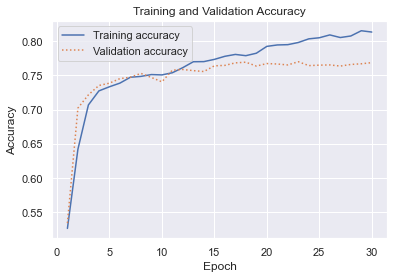

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()

In [129]:
models_performances = models_performances.append(
    pd.Series(data={'total training time': stop-start,
              'AUC': max(hist.history['val_auc']),
              'Accuracy': max(hist.history['val_accuracy']),
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

In [130]:
models_performances

,AUC,Accuracy,Epoch max reach,total training time,training time to opt
simple NN - raw text,0.814432,0.749333,8.0,12.445643,6.637676
simple NN - Basic preprocessing,0.817025,0.731667,7.0,11.445507,5.341237
simple NN - Stemming,0.823142,0.743667,6.0,10.423989,4.169596
simple NN - Lemmatization,0.823922,0.747333,6.0,11.959692,4.783877
simple NN - GLoVe embedding,0.788596,0.720000,11.0,7.094175,2.601198
LSTM - Own embedding,0.827899,0.744333,4.0,116.729051,15.563873
LSTM - GLoVe embedding,0.849900,0.770000,22.0,96.783377,70.974476


## Bi directional LSTM

In [131]:
from keras.layers import Bidirectional

In [132]:
model_name = 'biLSTM - GLoVe embedding'

lstm_out=64

model = Sequential()
#model.add(Embedding(len(voc),100 ,input_length = tweet_length))
model.add(embedding_layer)
model.add(Bidirectional(LSTM(lstm_out,dropout=0.2)))
#model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy','AUC'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 100)           2056600   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 2,141,209
Trainable params: 84,609
Non-trainable params: 2,056,600
_________________________________________________________________
None


In [133]:
start = time.time()
hist = model.fit(X_train_vect, y_train, batch_size=1024, epochs=30, validation_data=(X_test_vect, y_test))
stop = time.time()

Epoch 1/30
12/12 [==============================] - 6s 537ms/step - loss: 0.6701 - accuracy: 0.5965 - auc: 0.6507 - val_loss: 0.6352 - val_accuracy: 0.6737 - val_auc: 0.7465
Epoch 2/30
12/12 [==============================] - 5s 400ms/step - loss: 0.6066 - accuracy: 0.6827 - auc: 0.7446 - val_loss: 0.5706 - val_accuracy: 0.7123 - val_auc: 0.7773
Epoch 3/30
12/12 [==============================] - 6s 469ms/step - loss: 0.5521 - accuracy: 0.7179 - auc: 0.7909 - val_loss: 0.5389 - val_accuracy: 0.7293 - val_auc: 0.8035
Epoch 4/30
12/12 [==============================] - 5s 448ms/step - loss: 0.5323 - accuracy: 0.7298 - auc: 0.8089 - val_loss: 0.5258 - val_accuracy: 0.7343 - val_auc: 0.8179
Epoch 5/30
12/12 [==============================] - 5s 426ms/step - loss: 0.5159 - accuracy: 0.7436 - auc: 0.8234 - val_loss: 0.5238 - val_accuracy: 0.7420 - val_auc: 0.8219
Epoch 6/30
12/12 [==============================] - 6s 468ms/step - loss: 0.5098 - accuracy: 0.7473 - auc: 0.8277 - val_loss: 0.51

In [134]:
models_performances = models_performances.append(
    pd.Series(data={'total training time': stop-start,
              'AUC': max(hist.history['val_auc']),
              'Accuracy': max(hist.history['val_accuracy']),
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

In [135]:
models_performances.to_excel('data/perf_1K.xlsx')

[]

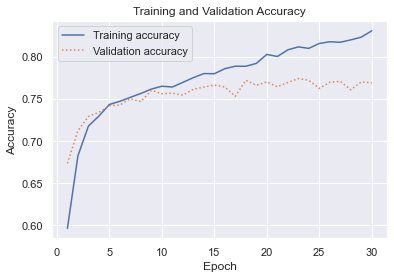

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()

In [137]:
models_performances

,AUC,Accuracy,Epoch max reach,total training time,training time to opt
simple NN - raw text,0.814432,0.749333,8.0,12.445643,6.637676
simple NN - Basic preprocessing,0.817025,0.731667,7.0,11.445507,5.341237
simple NN - Stemming,0.823142,0.743667,6.0,10.423989,4.169596
simple NN - Lemmatization,0.823922,0.747333,6.0,11.959692,4.783877
simple NN - GLoVe embedding,0.788596,0.720000,11.0,7.094175,2.601198
LSTM - Own embedding,0.827899,0.744333,4.0,116.729051,15.563873
LSTM - GLoVe embedding,0.849900,0.770000,22.0,96.783377,70.974476
biLSTM - GLoVe embedding,0.850876,0.774333,22.0,226.873566,166.373948


We will whoose LSTM+Glove as our best model based on accuracy and training time

# Model Optimization

Because of ressource limitation, we'll not perform a cross validation and gridsearch on hyperparameter, insted we'll just try different values and compare performance

In [138]:
hyperparamters_performances=pd.DataFrame(columns=['AUC','Accuracy_val','Epoch max reach'])

## Learning rate

In [139]:
model_name = 'LSTM - GLoVe embedding'
dp=0.2
lr=0.001
lstm_out=64

model = Sequential()
#model.add(Embedding(len(voc),100 ,input_length = tweet_length))
model.add(embedding_layer)
model.add(LSTM(lstm_out,dropout=dp))
#model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss = 'binary_crossentropy', optimizer=opt,metrics = ['accuracy','AUC'])

start = time.time()
hist = model.fit(X_train_vect, y_train, batch_size=1024, epochs=30, validation_data=(X_test_vect, y_test),verbose=0)
stop = time.time()

hyperparamters_performances = hyperparamters_performances.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
              'AUC': max(hist.history['val_auc']),
              'Accuracy_val': max(hist.history['val_accuracy']),
              'Accuracy_test': max(hist.history['accuracy']), 
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

In [140]:
model_name = 'LSTM - GLoVe embedding'
dp=0.2
lr=0.01
lstm_out=64

model = Sequential()
#model.add(Embedding(len(voc),100 ,input_length = tweet_length))
model.add(embedding_layer)
model.add(LSTM(lstm_out,dropout=dp))
#model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss = 'binary_crossentropy', optimizer=opt,metrics = ['accuracy','AUC'])

start = time.time()
hist = model.fit(X_train_vect, y_train, batch_size=1024, epochs=30, validation_data=(X_test_vect, y_test),verbose=0)
stop = time.time()

hyperparamters_performances = hyperparamters_performances.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
              'AUC': max(hist.history['val_auc']),
              'Accuracy_val': max(hist.history['val_accuracy']),
              'Accuracy_test': max(hist.history['accuracy']),   
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

In [141]:
model_name = 'LSTM - GLoVe embedding'
dp=0.2
lr=0.1
lstm_out=64

model = Sequential()
#model.add(Embedding(len(voc),100 ,input_length = tweet_length))
model.add(embedding_layer)
model.add(LSTM(lstm_out,dropout=dp))
#model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss = 'binary_crossentropy', optimizer=opt,metrics = ['accuracy','AUC'])

start = time.time()
hist = model.fit(X_train_vect, y_train, batch_size=1024, epochs=30, validation_data=(X_test_vect, y_test),verbose=0)
stop = time.time()

hyperparamters_performances = hyperparamters_performances.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
              'AUC': max(hist.history['val_auc']),
              'Accuracy_val': max(hist.history['val_accuracy']),
              'Accuracy_test': max(hist.history['accuracy']),
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

In [142]:
hyperparamters_performances

,AUC,Accuracy_val,Epoch max reach,Accuracy_test,dropout,learning_rate,lstm_out,total training time,training time to opt
LSTM - GLoVe embedding,0.850971,0.769000,25.0,0.810750,0.2,0.001,64.0,84.270123,70.225103
LSTM - GLoVe embedding,0.856207,0.774333,6.0,0.911583,0.2,0.010,64.0,85.980738,17.196148
LSTM - GLoVe embedding,0.831401,0.754000,19.0,0.758833,0.2,0.100,64.0,91.059850,57.671238


## Drop out

In [143]:
model_name = 'LSTM - GLoVe embedding'
dp=0
lr=0.01
lstm_out=64

model = Sequential()
#model.add(Embedding(len(voc),100 ,input_length = tweet_length))
model.add(embedding_layer)
model.add(LSTM(lstm_out,dropout=dp))
#model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss = 'binary_crossentropy', optimizer=opt,metrics = ['accuracy','AUC'])

start = time.time()
hist = model.fit(X_train_vect, y_train, batch_size=1024, epochs=60, validation_data=(X_test_vect, y_test),verbose=0)
stop = time.time()

hyperparamters_performances = hyperparamters_performances.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
              'AUC': max(hist.history['val_auc']),
              'Accuracy_val': max(hist.history['val_accuracy']),
              'Accuracy_test': max(hist.history['accuracy']),
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

In [144]:
model_name = 'LSTM - GLoVe embedding'
dp=0.1
lr=0.01
lstm_out=64

model = Sequential()
#model.add(Embedding(len(voc),100 ,input_length = tweet_length))
model.add(embedding_layer)
model.add(LSTM(lstm_out,dropout=dp))
#model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss = 'binary_crossentropy', optimizer=opt,metrics = ['accuracy','AUC'])

start = time.time()
hist = model.fit(X_train_vect, y_train, batch_size=1024, epochs=30, validation_data=(X_test_vect, y_test),verbose=0)
stop = time.time()

hyperparamters_performances = hyperparamters_performances.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
              'AUC': max(hist.history['val_auc']),
              'Accuracy_val': max(hist.history['val_accuracy']),
              'Accuracy_test': max(hist.history['accuracy']),
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

In [145]:
model_name = 'LSTM - GLoVe embedding'
dp=0.4
lr=0.01
lstm_out=64

model = Sequential()
#model.add(Embedding(len(voc),100 ,input_length = tweet_length))
model.add(embedding_layer)
model.add(LSTM(lstm_out,dropout=dp))
#model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss = 'binary_crossentropy', optimizer=opt,metrics = ['accuracy','AUC'])

start = time.time()
hist = model.fit(X_train_vect, y_train, batch_size=1024, epochs=30, validation_data=(X_test_vect, y_test),verbose=0)
stop = time.time()

hyperparamters_performances = hyperparamters_performances.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
              'AUC': max(hist.history['val_auc']),
              'Accuracy_val': max(hist.history['val_accuracy']),
              'Accuracy_test': max(hist.history['accuracy']),
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

In [146]:
model_name = 'LSTM - GLoVe embedding'
dp=0.8
lr=0.01
lstm_out=64

model = Sequential()
#model.add(Embedding(len(voc),100 ,input_length = tweet_length))
model.add(embedding_layer)
model.add(LSTM(lstm_out,dropout=dp))
#model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss = 'binary_crossentropy', optimizer=opt,metrics = ['accuracy','AUC'])

start = time.time()
hist = model.fit(X_train_vect, y_train, batch_size=1024, epochs=30, validation_data=(X_test_vect, y_test),verbose=0)
stop = time.time()

hyperparamters_performances = hyperparamters_performances.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
              'AUC': max(hist.history['val_auc']),
              'Accuracy_val': max(hist.history['val_accuracy']),
              'Accuracy_test': max(hist.history['accuracy']),
              'Epoch max reach': hist.history['val_accuracy'].index(max(hist.history['val_accuracy'])),
              'training time to opt' : (stop-start)*hist.history['val_accuracy'].index(max(hist.history['val_accuracy']))/len(hist.history['val_accuracy'])},
              name=model_name)
)

In [147]:
hyperparamters_performances

,AUC,Accuracy_val,Epoch max reach,Accuracy_test,dropout,learning_rate,lstm_out,total training time,training time to opt
LSTM - GLoVe embedding,0.850971,0.769000,25.0,0.810750,0.2,0.001,64.0,84.270123,70.225103
LSTM - GLoVe embedding,0.856207,0.774333,6.0,0.911583,0.2,0.010,64.0,85.980738,17.196148
LSTM - GLoVe embedding,0.831401,0.754000,19.0,0.758833,0.2,0.100,64.0,91.059850,57.671238
LSTM - GLoVe embedding,0.857739,0.776333,4.0,0.988583,0.0,0.010,64.0,141.047381,9.403159
LSTM - GLoVe embedding,0.857067,0.780667,13.0,0.955167,0.1,0.010,64.0,114.911483,49.794976
LSTM - GLoVe embedding,0.865676,0.788000,18.0,0.838333,0.4,0.010,64.0,111.909359,67.145615
LSTM - GLoVe embedding,0.835527,0.758333,24.0,0.704250,0.8,0.010,64.0,90.931730,72.745384


In [148]:
hyperparamters_performances.to_excel('data/hyp_perf_15K.xlsx')